In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 713.1062, train_label_loss: 2.8216, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11727.7850, train_label_loss: 2.7149, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11758.7220, train_label_loss: 2.6033, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11784.8378, train_label_loss: 2.5202, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11696.6815, train_label_loss: 2.2961, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11730.7862, train_label_loss: 2.1301, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11660.0967, train_label_loss: 2.0507, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11613.2928, train_label_loss: 1.7957, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11698.0504, train_label_loss: 1.7544, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11399.6171, train_label_loss: 1.4919, 


epoch: 1, source_val_acc_label: 0.6123, source_val_label_loss: 1.3601, target_val_acc_label: 0.6123, target_val_label_loss: 1.3601, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 56.0042, train_label_loss: 1.4574, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11569.0911, train_label_loss: 1.3813, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11617.0855, train_label_loss: 1.2111, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11595.7613, train_label_loss: 1.1166, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11620.1945, train_label_loss: 1.1297, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11711.1356, train_label_loss: 0.9913, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11618.1468, train_label_loss: 0.9396, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11716.1412, train_label_loss: 0.9316, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11528.3274, train_label_loss: 0.7211, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11622.5178, train_label_loss: 0.6586, 


epoch: 2, source_val_acc_label: 0.8549, source_val_label_loss: 0.6369, target_val_acc_label: 0.8549, target_val_label_loss: 0.6369, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 64.3876, train_label_loss: 0.7573, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 12297.4821, train_label_loss: 0.6301, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11691.7453, train_label_loss: 0.6593, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11550.0856, train_label_loss: 0.6105, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11669.9362, train_label_loss: 0.5531, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11570.1714, train_label_loss: 0.4198, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11538.5319, train_label_loss: 0.4471, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11611.2960, train_label_loss: 0.4533, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11735.8379, train_label_loss: 0.4251, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11942.4906, train_label_loss: 0.4470, 


epoch: 3, source_val_acc_label: 0.9046, source_val_label_loss: 0.3884, target_val_acc_label: 0.9046, target_val_label_loss: 0.3884, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 63.8362, train_label_loss: 0.3236, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11570.4848, train_label_loss: 0.3472, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11704.4281, train_label_loss: 0.3789, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11703.3874, train_label_loss: 0.3031, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11579.3833, train_label_loss: 0.8126, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11583.4896, train_label_loss: 0.3123, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11580.4984, train_label_loss: 0.4826, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11512.9485, train_label_loss: 0.3568, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11721.9370, train_label_loss: 0.4031, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11607.6701, train_label_loss: 0.3626, 


epoch: 4, source_val_acc_label: 0.9237, source_val_label_loss: 0.2948, target_val_acc_label: 0.9237, target_val_label_loss: 0.2948, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 63.9895, train_label_loss: 0.3152, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11746.0415, train_label_loss: 0.3342, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11725.1572, train_label_loss: 0.3700, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11784.7232, train_label_loss: 0.3175, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11755.9890, train_label_loss: 0.3126, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11693.8335, train_label_loss: 0.4035, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11727.9601, train_label_loss: 0.2009, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11713.9080, train_label_loss: 0.3454, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11794.9538, train_label_loss: 0.2664, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11772.2439, train_label_loss: 0.2881, 


epoch: 5, source_val_acc_label: 0.9340, source_val_label_loss: 0.2551, target_val_acc_label: 0.9340, target_val_label_loss: 0.2551, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 64.9612, train_label_loss: 0.2459, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11600.8666, train_label_loss: 0.2756, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11764.7148, train_label_loss: 0.2464, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11782.2422, train_label_loss: 0.3513, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11794.1283, train_label_loss: 0.1501, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11777.2852, train_label_loss: 0.1779, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11805.0038, train_label_loss: 0.2939, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11718.5304, train_label_loss: 0.3865, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11733.2346, train_label_loss: 0.2128, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11774.6580, train_label_loss: 0.2631, 


epoch: 6, source_val_acc_label: 0.9301, source_val_label_loss: 0.2279, target_val_acc_label: 0.9301, target_val_label_loss: 0.2279, 


epoch: 7, [batch: 1 / 1400], examples_per_second: 65.2144, train_label_loss: 0.2471, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11778.4800, train_label_loss: 0.2604, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11783.2434, train_label_loss: 0.1593, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11724.1879, train_label_loss: 0.2438, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11773.5974, train_label_loss: 0.2972, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11781.1231, train_label_loss: 0.1802, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11755.8787, train_label_loss: 0.2435, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11794.9612, train_label_loss: 0.2200, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11776.2999, train_label_loss: 0.2741, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11748.4257, train_label_loss: 0.2090, 


epoch: 7, source_val_acc_label: 0.9484, source_val_label_loss: 0.1768, target_val_acc_label: 0.9484, target_val_label_loss: 0.1768, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 64.3211, train_label_loss: 0.1899, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11599.3122, train_label_loss: 0.2294, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11665.4117, train_label_loss: 0.1945, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11737.8576, train_label_loss: 0.1402, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11763.6800, train_label_loss: 0.1517, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11598.4884, train_label_loss: 0.1565, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11657.4310, train_label_loss: 0.1416, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11711.6374, train_label_loss: 0.1714, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11649.8278, train_label_loss: 0.2177, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11770.4022, train_label_loss: 0.2893, 


epoch: 8, source_val_acc_label: 0.9390, source_val_label_loss: 0.1943, target_val_acc_label: 0.9390, target_val_label_loss: 0.1943, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 63.6836, train_label_loss: 0.3681, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11654.6874, train_label_loss: 0.1361, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11796.9939, train_label_loss: 0.1280, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11819.5727, train_label_loss: 0.1206, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11833.9280, train_label_loss: 0.1866, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11819.6954, train_label_loss: 0.1760, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 12197.2772, train_label_loss: 0.2076, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 12636.0051, train_label_loss: 0.1808, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 12662.4295, train_label_loss: 0.1793, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 12580.9224, train_label_loss: 0.1955, 


epoch: 9, source_val_acc_label: 0.9485, source_val_label_loss: 0.1794, target_val_acc_label: 0.9485, target_val_label_loss: 0.1794, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 71.0942, train_label_loss: 0.2457, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 12510.7453, train_label_loss: 0.1949, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11982.8125, train_label_loss: 0.1351, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 10774.4562, train_label_loss: 0.0869, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 10693.5624, train_label_loss: 0.1133, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 10703.2306, train_label_loss: 0.0793, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 10723.3155, train_label_loss: 0.1326, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 10665.7944, train_label_loss: 0.1144, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 10639.4216, train_label_loss: 0.1758, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 10702.8739, train_label_loss: 0.1219, 


epoch: 10, source_val_acc_label: 0.9444, source_val_label_loss: 0.1830, target_val_acc_label: 0.9444, target_val_label_loss: 0.1830, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 57.7271, train_label_loss: 0.1174, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 10701.3355, train_label_loss: 0.1557, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 10691.3173, train_label_loss: 0.0461, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 10738.6056, train_label_loss: 0.2169, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 10658.0054, train_label_loss: 0.1612, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 10658.6735, train_label_loss: 0.1249, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 10748.2663, train_label_loss: 0.0829, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 10718.0736, train_label_loss: 0.0922, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 10686.2904, train_label_loss: 0.1653, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 10651.9712, train_label_loss: 0.1196, 


epoch: 11, source_val_acc_label: 0.9536, source_val_label_loss: 0.1561, target_val_acc_label: 0.9536, target_val_label_loss: 0.1561, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 56.6838, train_label_loss: 0.1093, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 10602.6818, train_label_loss: 0.1189, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 10612.8881, train_label_loss: 0.1575, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 10714.3609, train_label_loss: 0.0779, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 10704.8343, train_label_loss: 0.1102, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 10700.2898, train_label_loss: 0.1757, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 10666.0744, train_label_loss: 0.1201, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 10645.5758, train_label_loss: 0.1854, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10745.7938, train_label_loss: 0.0929, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10709.7488, train_label_loss: 0.1262, 


epoch: 12, source_val_acc_label: 0.9524, source_val_label_loss: 0.1406, target_val_acc_label: 0.9524, target_val_label_loss: 0.1406, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 56.7414, train_label_loss: 0.1782, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10700.5376, train_label_loss: 0.1204, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10713.3576, train_label_loss: 0.1194, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10718.0996, train_label_loss: 0.1100, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10673.0733, train_label_loss: 0.1178, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10864.2632, train_label_loss: 0.1166, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10596.4342, train_label_loss: 0.1143, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10650.8466, train_label_loss: 0.2219, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10643.5452, train_label_loss: 0.1586, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10740.7494, train_label_loss: 0.0872, 


epoch: 13, source_val_acc_label: 0.9608, source_val_label_loss: 0.1349, target_val_acc_label: 0.9608, target_val_label_loss: 0.1349, 


New best
epoch: 14, [batch: 1 / 1400], examples_per_second: 57.3375, train_label_loss: 0.1013, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10695.3325, train_label_loss: 0.1695, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10644.7526, train_label_loss: 0.1062, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10694.5895, train_label_loss: 0.0867, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10743.8354, train_label_loss: 0.1172, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10726.3869, train_label_loss: 0.1181, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10725.8695, train_label_loss: 0.1163, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10683.8616, train_label_loss: 0.1292, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10779.6684, train_label_loss: 0.0688, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10678.1302, train_label_loss: 0.1010, 


epoch: 14, source_val_acc_label: 0.9517, source_val_label_loss: 0.1445, target_val_acc_label: 0.9517, target_val_label_loss: 0.1445, 


epoch: 15, [batch: 1 / 1400], examples_per_second: 57.6583, train_label_loss: 0.1342, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10619.4053, train_label_loss: 0.1132, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10729.9104, train_label_loss: 0.1194, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10723.7791, train_label_loss: 0.0575, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10700.3614, train_label_loss: 0.0764, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10768.5054, train_label_loss: 0.0740, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10713.5821, train_label_loss: 0.1165, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10737.8278, train_label_loss: 0.0648, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10743.2104, train_label_loss: 0.0685, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10741.3358, train_label_loss: 0.1232, 


epoch: 15, source_val_acc_label: 0.9585, source_val_label_loss: 0.1249, target_val_acc_label: 0.9585, target_val_label_loss: 0.1249, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 57.3626, train_label_loss: 0.1415, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10686.2809, train_label_loss: 0.0983, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 10701.7219, train_label_loss: 0.1284, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 10710.9576, train_label_loss: 0.1327, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 10711.0385, train_label_loss: 0.0997, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 10727.4769, train_label_loss: 0.1327, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 10691.4420, train_label_loss: 0.0957, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 10688.2280, train_label_loss: 0.1257, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 10773.4323, train_label_loss: 0.1626, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 10699.9592, train_label_loss: 0.0676, 


epoch: 16, source_val_acc_label: 0.9581, source_val_label_loss: 0.1403, target_val_acc_label: 0.9581, target_val_label_loss: 0.1403, 


epoch: 17, [batch: 1 / 1400], examples_per_second: 58.1089, train_label_loss: 0.0942, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 10647.7656, train_label_loss: 0.1657, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 10719.1971, train_label_loss: 0.0672, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 10732.6361, train_label_loss: 0.1132, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 10738.3678, train_label_loss: 0.1381, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 10725.8971, train_label_loss: 0.1372, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 10289.3072, train_label_loss: 0.2511, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 10730.3990, train_label_loss: 0.1137, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 10691.0344, train_label_loss: 0.1426, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 10704.9059, train_label_loss: 0.0703, 


epoch: 17, source_val_acc_label: 0.9596, source_val_label_loss: 0.3663, target_val_acc_label: 0.9596, target_val_label_loss: 0.3663, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

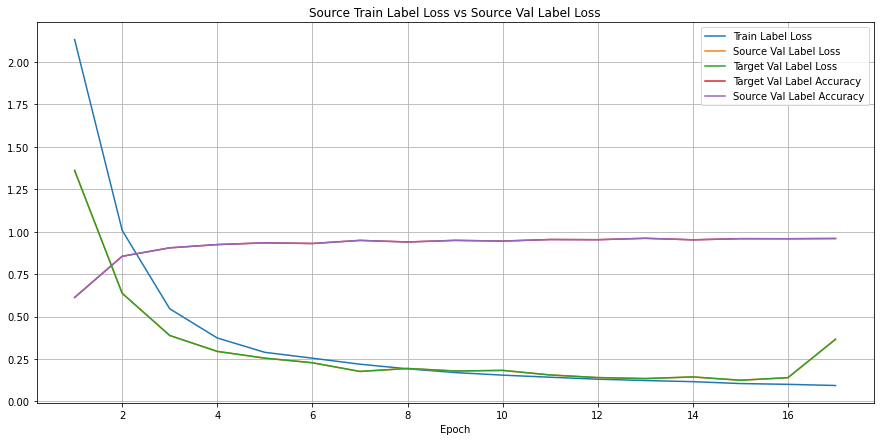

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

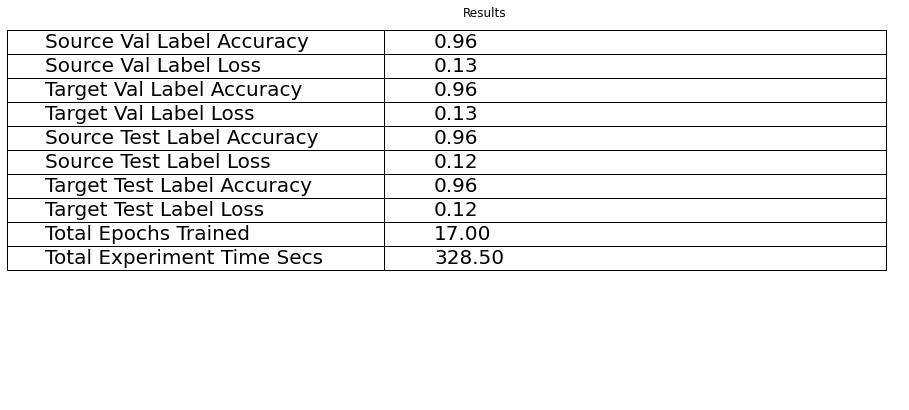

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

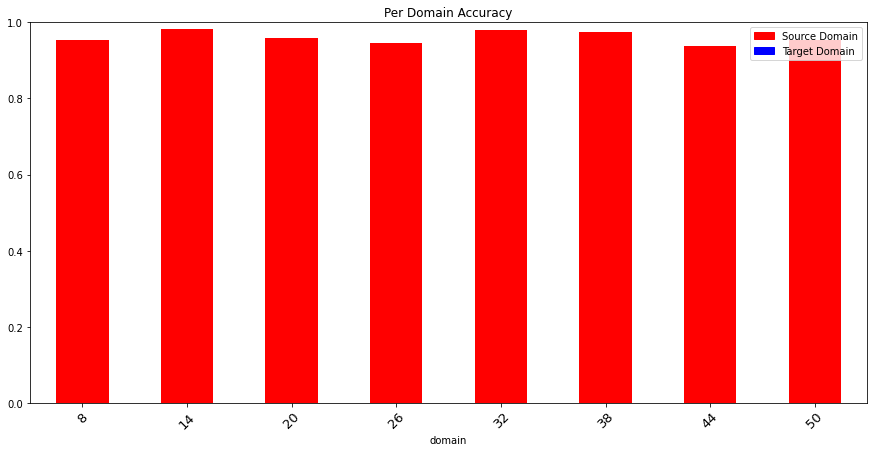

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.961953125 Target Test Label Accuracy: 0.961953125
Source Val Label Accuracy: 0.9607552083333334 Target Val Label Accuracy: 0.9607552083333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1.framed", "parameters": {"experiment_name": "cnn_2:oracle.run1.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch